In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import math
import csv
import numpy as np
from copy import copy
from numpy.random import randn

In [2]:
# add the local src directory into the module path
import sys
sys.path.insert(1, '../src')
from tank_kalman_delta_2 import TankKalmanDelta2, TankControlModel

## Read in the data

In [3]:
with open('sim_fast_s_turn.csv') as fin:
    csvin = csv.reader(fin)
    column_names = next(csvin)
    data_rows = []
    for r in csvin:
        data_rows.append([float(x) for x in r])
column_names

['Time',
 'X',
 'Y',
 'Angle',
 'EncoderLeft',
 'EncoderRight',
 'Motor_Left',
 'Motor_Right']

In [4]:
def plot_fit(title, t, real, kal, cov=None):
    plt.rcParams['figure.figsize'] = (16,5)
    
    f, (ax1, ax2) = plt.subplots(1, 2)
#    print(ax1)
    ax1.set_title(title)
    ax1.plot(t, real, color='green')
    ax1.plot(t, kal, color='red')
    if cov is not None:
        dx = np.sqrt(cov)
        ax1.plot(t, np.add(kal, dx), color='orange')
        ax1.plot(t, np.subtract(kal, dx), color='orange')
    
    ax2.set_title(title + ' - Difference from Real')
    #plt.plot(t, x_real, color='green')
    ax2.plot(t, np.subtract(kal, real), color='red')
    if cov is not None:
        ax2.plot(t, np.subtract(np.add(kal, dx), real), color='orange')
        ax2.plot(t, np.subtract(np.subtract(kal, dx), real), color='orange')
    plt.show()
    return

In [5]:
std_x, std_y, std_a = .1, .1, math.radians(2.0)
wheel_base = 22.0/12.0

np.random.seed(1234)

t = [r[0] for r in data_rows]

dt = t[1] - t[0]
x_real = [r[1] for r in data_rows]
y_real = [r[2] for r in data_rows]
a_real = [math.degrees(r[3]) for r in data_rows]
#va_real = np.gradient(a_real) /dt

## Use exact measurements

In [22]:
# angle uncertainty from NavX is 1 deg
meas_da = math.radians(1.0)
# sigma_enc = 0.5 inch per foot traveled 
var_rate_enc = (0.5/12.0)**2 / 12.0

ind_l = column_names.index('EncoderLeft')
ind_r = column_names.index('EncoderRight')
ind_a = column_names.index('Angle')
ind_m_l = column_names.index('Motor_Left')
ind_m_r = column_names.index('Motor_Right')

ctrl_model = TankControlModel()
kf = TankKalmanDelta2(dt, wheel_base, var_rate_enc, meas_da, control_model=ctrl_model,
                      var_a_s=0.1, var_a_p=0.1, var_a_a=math.radians(0.5)**2)

print('acceleration sigma =', math.sqrt(kf.var_a_s), 'ft/sec^2')
print('angle acc sigma =', math.degrees(math.sqrt(kf.var_a_a)), 'degs/sec^2')

res = [np.copy(kf.x),]
for r in data_rows[1:]:
    motors = [r[ind_m_l], r[ind_m_r]]
    kf.predict(dt, motors=motors)
    kf.update(r[ind_l], r[ind_r], r[ind_a])
    res.append(np.copy(kf.x))

acceleration sigma = 0.31622776601683794 ft/sec^2
angle acc sigma = 0.5 degs/sec^2


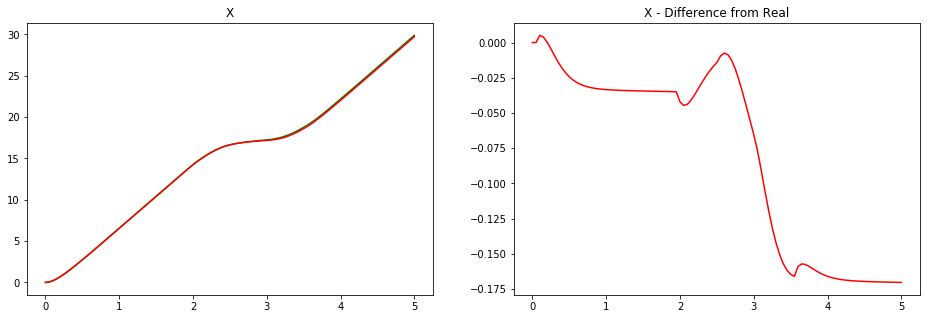

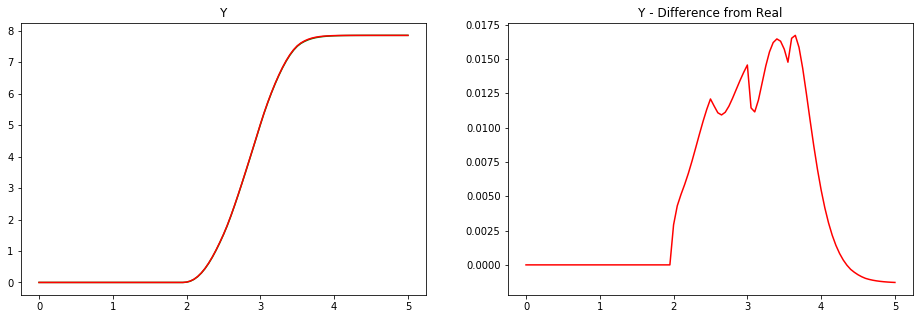

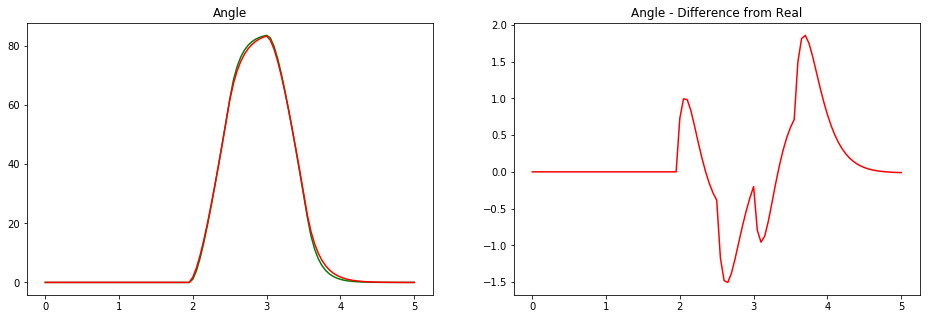

In [23]:
#x_cov = [m[0,0] for m in xcov3]
x_kal = [r[0] for r in res]
plot_fit("X", t, x_real, x_kal)

y_kal = [r[1] for r in res]
#y_cov = [m[2,2] for m in xcov3]
plot_fit("Y", t, y_real, y_kal)

a_kal = [math.degrees(r[4]) for r in res]
#a_cov = [math.degrees(math.sqrt(m[4,4]))**2 for m in xcov3]
plot_fit("Angle", t, a_real, a_kal);

**Not bad**  The residual errors might be do to the discrete (step) calculation of the state change. An indication of this is that it really goes off when we start turning, which is when the non-linearity kicks in. We can try lots of small steps, or eventually Runge-Kutta integration (but that is kind of complicated).

## Add some noise

In [26]:
# angle uncertainty from NavX is 1 deg
meas_da = math.radians(1.0)
# sigma_enc = (0.5/12.) per foot traveled 
var_rate_enc = (0.5/12.0)**2 / 12.0

ind_l = column_names.index('EncoderLeft')
ind_r = column_names.index('EncoderRight')
ind_a = column_names.index('Angle')
ind_m_l = column_names.index('Motor_Left')
ind_m_r = column_names.index('Motor_Right')

ctrl_model = TankControlModel()
kf = TankKalmanDelta2(dt, wheel_base, var_rate_enc, meas_da, control_model=ctrl_model,
                      var_a_s=0.1, var_a_p=0.1, var_a_a=math.radians(0.5)**2)

print('acceleration sigma =', math.sqrt(kf.var_a_s), 'ft/sec^2')
print('angle acc sigma =', math.degrees(math.sqrt(kf.var_a_a)), 'degs/sec^2')

res = [np.copy(kf.x),]
for r in data_rows[1:]:
    motors = [r[ind_m_l], r[ind_m_r]]
    kf.predict(dt, motors=motors)
    kf.update(r[ind_l] + randn()*math.sqrt(var_rate_enc * r[ind_l]),
              r[ind_r] + randn()*math.sqrt(var_rate_enc * r[ind_r]), 
              r[ind_a] + randn()*meas_da)
    res.append(np.copy(kf.x))

acceleration sigma = 0.31622776601683794 ft/sec^2
angle acc sigma = 0.5 degs/sec^2


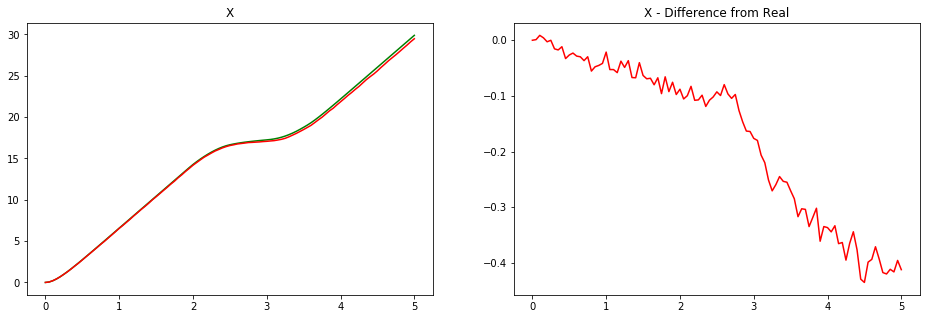

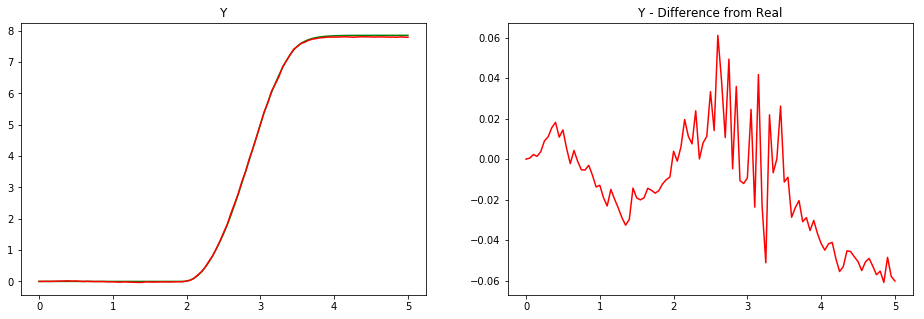

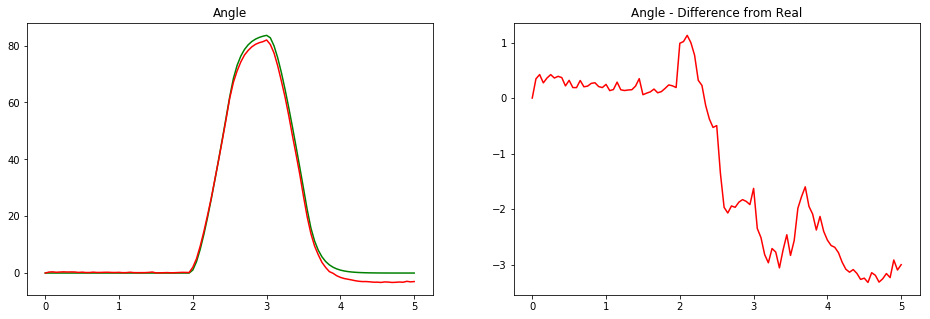

In [27]:
plt.rcParams['figure.figsize'] = (16,5)
#x_cov = [m[0,0] for m in xcov3]
x_kal = [r[0] for r in res]
plot_fit("X", t, x_real, x_kal)

y_kal = [r[1] for r in res]
#y_cov = [m[2,2] for m in xcov3]
plot_fit("Y", t, y_real, y_kal)

a_kal = [math.degrees(r[4]) for r in res]
#a_cov = [math.degrees(math.sqrt(m[4,4]))**2 for m in xcov3]
plot_fit("Angle", t, a_real, a_kal);

Not quite as pretty. The angle is affected heavily, but maybe I am just adding in too much noise.

In particular, I have the NavX yaw uncertainty as a fixed number, but we know it builds over time, and should be quite accurate over a few seconds.